In [1]:
#Librerías para manejo de datos
import pandas as pd
import numpy as np

#Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelar
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedGroupKFold, StratifiedKFold, KFold,RandomizedSearchCV, RepeatedKFold, GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score, make_scorer, classification_report
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

#Librería para tendencia al cluster
from pyclustertend import hopkins
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

#Librerías para visualización de barrios
import geopandas as gp
from seaborn import color_palette
import matplotlib.colors as colors

#grafico del arbol
from six import StringIO
from IPython.display import Image  
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree #,export_graphviz
import sklearn as sk

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
import multiprocessing

from sklearn.svm import SVC

In [2]:
import matplotlib                                #  ESTO ARREGLA EL ERROR
from matplotlib import rcParams, rcParamsDefault #  findfont: Generic family 'sans-serif' not found because none of the following families were found: 
rcParams.update(rcParamsDefault)                 #  BORRAR UNA VEZ SEGUROS QUE YA NO PASE

# Ejercicio 3

## Construccion del target

Para esta tarea se debe crear una nueva variable tipo_precio que tendrá tres categorías: alto, medio, bajo. Esta nueva variable será nuestra clase en el problema de clasificación.
Para determinar cuándo el tipo_precio de una propiedad es alto, medio o bajo se deberá analizar el precio por metro cuadrado (pxm2). Se propone evaluar las siguientes alternativas para establecer los límites de cada categoría.

In [3]:
df_tprecio = pd.read_csv('./data/properati_argentina_2021_filtrado.csv')
df_tprecio['pxm2'] = round(df_tprecio["property_price"] / df_tprecio['property_surface_total'], 0)
df_tprecio

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,pxm2
0,-34.589974,-58.459133,Palermo,Casa,4,3,171.000000,133.0,210000.0,1228.0
1,-34.637319,-58.361124,Boca,Departamento,3,2,58.000000,55.0,82900.0,1429.0
2,-34.628647,-58.361871,Boca,Departamento,4,3,70.000000,70.0,99000.0,1414.0
3,-34.610027,-58.401934,Once,Departamento,4,2,135.327513,104.0,146000.0,1079.0
4,-34.631621,-58.416825,Boedo,PH,4,2,106.415511,73.0,250000.0,2349.0
...,...,...,...,...,...,...,...,...,...,...
82658,-34.603245,-58.489810,Villa del Parque,Departamento,4,3,130.000000,100.0,220000.0,1692.0
82659,-34.614063,-58.482814,Villa del Parque,Departamento,3,2,68.000000,60.0,161000.0,2368.0
82660,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,51.000000,30.0,75500.0,1480.0
82661,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,37.000000,31.0,74500.0,2014.0


Buscamos posibles outliers en el nuevo atributo creado

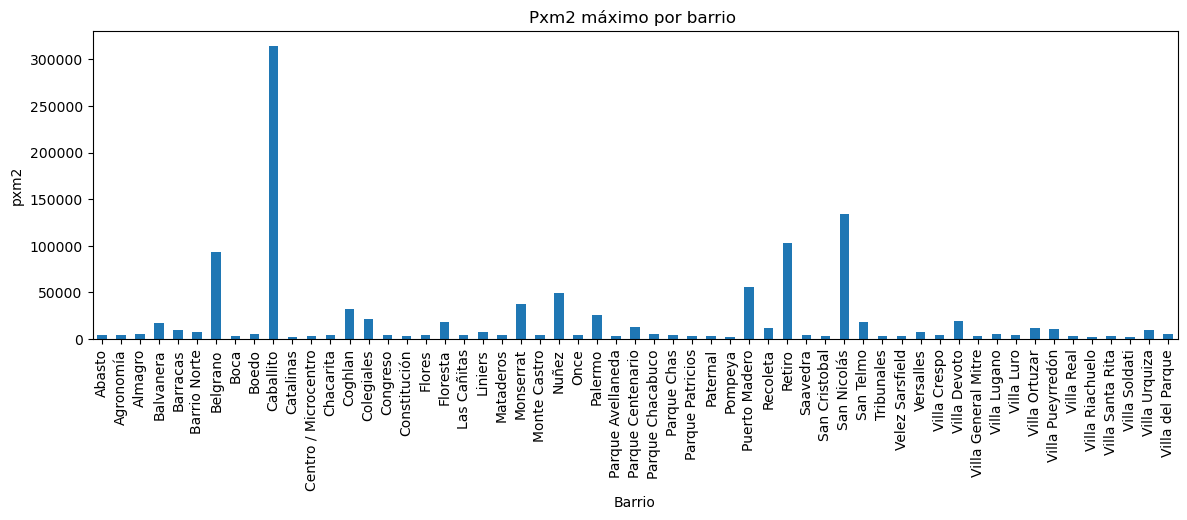

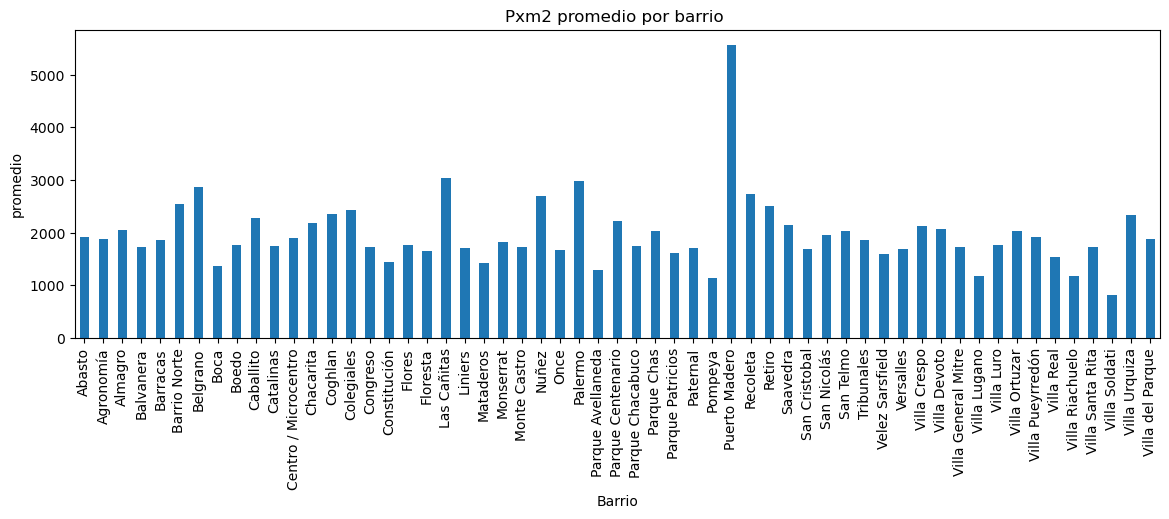

In [4]:
plt.rcParams['figure.figsize'] = (14,4)
df_tprecio.groupby(by=['place_l3'])['pxm2'].max().plot.bar(alpha=1 , title="Pxm2 máximo por barrio " , xlabel="Barrio" , ylabel="pxm2")
plt.show()

promedios_por_barrio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean()
promedios_por_barrio.plot.bar(alpha=1 , title="Pxm2 promedio por barrio " , xlabel="Barrio" , ylabel="promedio")
plt.show()

Si bien el promedio se ve bien, notamos la precencia de varios outliers. Procedemos a normalizar los valores de pxm2 para asi eliminar los outliers.

In [5]:
# Este max_pxm2_promedio va a ser el valor de arriba de Puerto Madero
max_pxm2_promedio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean().max();
promedios_por_barrio_dict = promedios_por_barrio.to_dict()
promedios_por_barrio_dict

{'Abasto': 1926.9064039408868,
 'Agronomía': 1873.762331838565,
 'Almagro': 2060.8274311410905,
 'Balvanera': 1730.6389010030528,
 'Barracas': 1869.8166368515206,
 'Barrio Norte': 2539.3086705202313,
 'Belgrano': 2873.575876504448,
 'Boca': 1367.442815249267,
 'Boedo': 1766.0113339145598,
 'Caballito': 2281.7981694073846,
 'Catalinas': 1743.2857142857142,
 'Centro / Microcentro': 1894.9714285714285,
 'Chacarita': 2186.8810289389066,
 'Coghlan': 2358.766101694915,
 'Colegiales': 2435.2088681446908,
 'Congreso': 1721.155069582505,
 'Constitución': 1436.0171149144255,
 'Flores': 1771.655524278677,
 'Floresta': 1654.157943067034,
 'Las Cañitas': 3039.5384615384614,
 'Liniers': 1703.462311557789,
 'Mataderos': 1430.6196136701337,
 'Monserrat': 1821.0841683366734,
 'Monte Castro': 1725.2820512820513,
 'Nuñez': 2700.768190598841,
 'Once': 1670.8147368421053,
 'Palermo': 2989.9707736389687,
 'Parque Avellaneda': 1290.7602179836513,
 'Parque Centenario': 2222.2934782608695,
 'Parque Chacabuco':

In [6]:
def corregir_pxm2(pxm2, place):
    return pxm2 if pxm2 < max_pxm2_promedio else round(promedios_por_barrio_dict[place], 0)

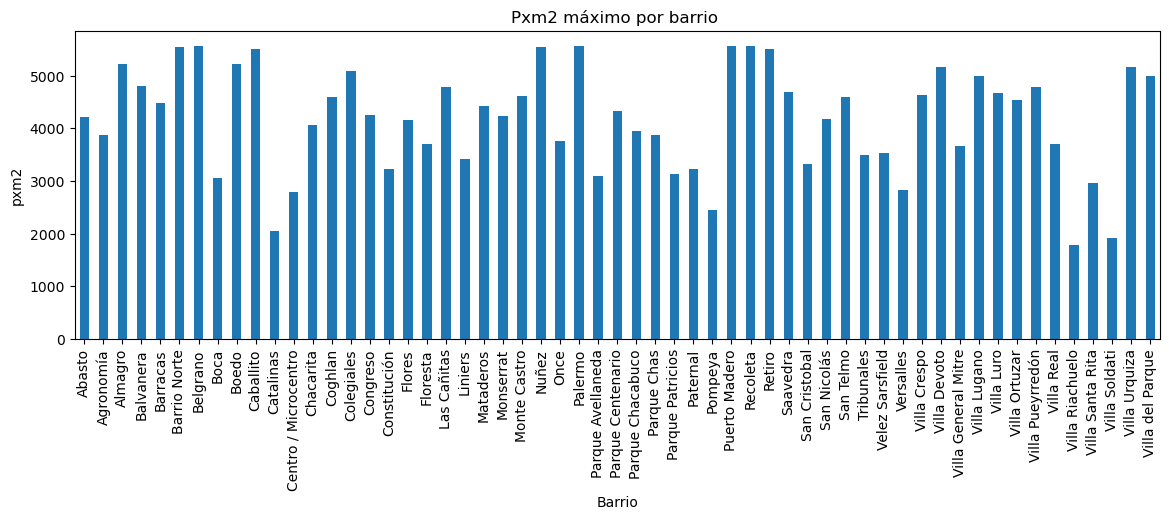

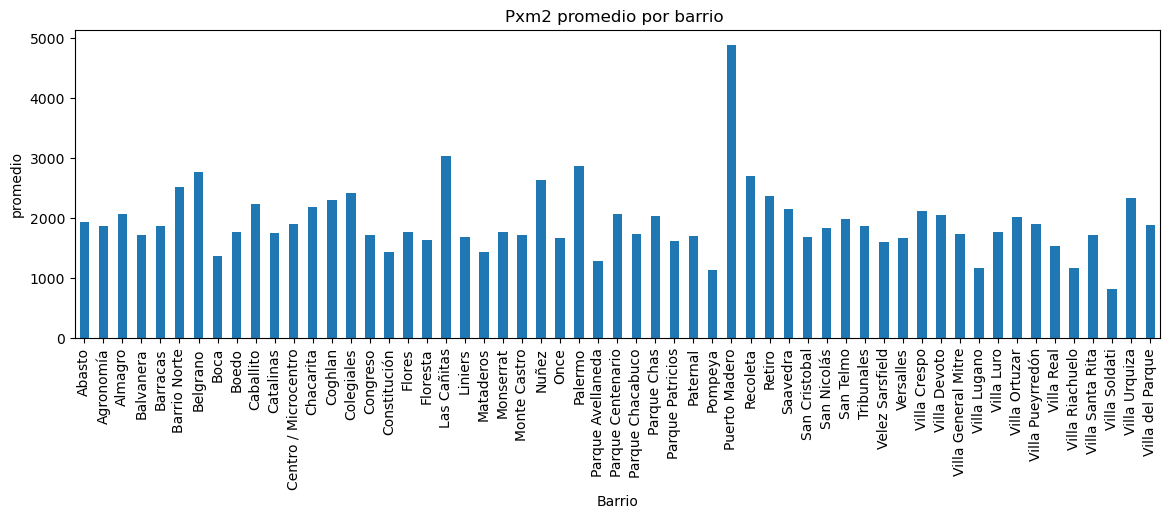

In [7]:
df_tprecio['pxm2'] = df_tprecio.apply(lambda row: corregir_pxm2(row['pxm2'], row['place_l3']), axis=1)

# Verificamos que los máximos de cada barrio estén más normalizados

plt.rcParams['figure.figsize'] = (14,4)
df_tprecio.groupby(by=['place_l3'])['pxm2'].max().plot.bar(alpha=1 , title="Pxm2 máximo por barrio " , xlabel="Barrio" , ylabel="pxm2")
plt.show()

promedios_por_barrio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean()
promedios_por_barrio.plot.bar(alpha=1 , title="Pxm2 promedio por barrio " , xlabel="Barrio" , ylabel="promedio")
plt.show()

### Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

In [8]:
df_tprecio1 = df_tprecio.copy()

In [9]:
df_tprecio1["tipo_precio"] = pd.qcut( df_tprecio1["pxm2"],
                            q=3, # Separo en tres categorias iguales
                            labels=["bajo", "medio", "alto"])

df_tprecio1

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,pxm2,tipo_precio
0,-34.589974,-58.459133,Palermo,Casa,4,3,171.000000,133.0,210000.0,1228.0,bajo
1,-34.637319,-58.361124,Boca,Departamento,3,2,58.000000,55.0,82900.0,1429.0,bajo
2,-34.628647,-58.361871,Boca,Departamento,4,3,70.000000,70.0,99000.0,1414.0,bajo
3,-34.610027,-58.401934,Once,Departamento,4,2,135.327513,104.0,146000.0,1079.0,bajo
4,-34.631621,-58.416825,Boedo,PH,4,2,106.415511,73.0,250000.0,2349.0,medio
...,...,...,...,...,...,...,...,...,...,...,...
82658,-34.603245,-58.489810,Villa del Parque,Departamento,4,3,130.000000,100.0,220000.0,1692.0,bajo
82659,-34.614063,-58.482814,Villa del Parque,Departamento,3,2,68.000000,60.0,161000.0,2368.0,medio
82660,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,51.000000,30.0,75500.0,1480.0,bajo
82661,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,37.000000,31.0,74500.0,2014.0,medio


Verifico que se haya separado (aproximadamente) en partes iguales

In [10]:
df_tprecio1["tipo_precio"].value_counts()

medio    27564
bajo     27558
alto     27541
Name: tipo_precio, dtype: int64

### Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones, el siguiente con el 50% y el ultimo con el 25% de las observaciones restantes.

In [11]:
df_tprecio2 = df_tprecio.copy()

In [12]:
df_tprecio2["tipo_precio"] = pd.qcut( df_tprecio2["pxm2"],
                            [0, .25, .75, 1],
                            labels=["bajo", "medio", "alto"])

df_tprecio2

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,pxm2,tipo_precio
0,-34.589974,-58.459133,Palermo,Casa,4,3,171.000000,133.0,210000.0,1228.0,bajo
1,-34.637319,-58.361124,Boca,Departamento,3,2,58.000000,55.0,82900.0,1429.0,bajo
2,-34.628647,-58.361871,Boca,Departamento,4,3,70.000000,70.0,99000.0,1414.0,bajo
3,-34.610027,-58.401934,Once,Departamento,4,2,135.327513,104.0,146000.0,1079.0,bajo
4,-34.631621,-58.416825,Boedo,PH,4,2,106.415511,73.0,250000.0,2349.0,medio
...,...,...,...,...,...,...,...,...,...,...,...
82658,-34.603245,-58.489810,Villa del Parque,Departamento,4,3,130.000000,100.0,220000.0,1692.0,bajo
82659,-34.614063,-58.482814,Villa del Parque,Departamento,3,2,68.000000,60.0,161000.0,2368.0,medio
82660,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,51.000000,30.0,75500.0,1480.0,bajo
82661,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,37.000000,31.0,74500.0,2014.0,medio


In [13]:
df_tprecio2["tipo_precio"].value_counts()

medio    41404
bajo     20696
alto     20563
Name: tipo_precio, dtype: int64

La categoria "medio" representa el 50% de las observaciones, mientras que tanto "bajo" como "alto" posee un 25% cada una.

### Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en el punto anterior.

In [14]:
df_tprecio3 = df_tprecio.copy()

In [15]:
df_tprecio3["tipo_precio"] = df_tprecio3.groupby("property_type").apply(
                            lambda propiedad: 
                                pd.qcut(propiedad['pxm2'], 
                                [0, .25, .75, 1], 
                                labels=["bajo", "medio", "alto"]
                            )).reset_index(drop=True)

df_tprecio3

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,pxm2,tipo_precio
0,-34.589974,-58.459133,Palermo,Casa,4,3,171.000000,133.0,210000.0,1228.0,medio
1,-34.637319,-58.361124,Boca,Departamento,3,2,58.000000,55.0,82900.0,1429.0,medio
2,-34.628647,-58.361871,Boca,Departamento,4,3,70.000000,70.0,99000.0,1414.0,medio
3,-34.610027,-58.401934,Once,Departamento,4,2,135.327513,104.0,146000.0,1079.0,alto
4,-34.631621,-58.416825,Boedo,PH,4,2,106.415511,73.0,250000.0,2349.0,medio
...,...,...,...,...,...,...,...,...,...,...,...
82658,-34.603245,-58.489810,Villa del Parque,Departamento,4,3,130.000000,100.0,220000.0,1692.0,medio
82659,-34.614063,-58.482814,Villa del Parque,Departamento,3,2,68.000000,60.0,161000.0,2368.0,alto
82660,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,51.000000,30.0,75500.0,1480.0,alto
82661,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,37.000000,31.0,74500.0,2014.0,alto


In [16]:
df_tprecio3["tipo_precio"].value_counts()

medio    41279
bajo     20719
alto     20665
Name: tipo_precio, dtype: int64

# Ejercicio 3a

### Mostrar la distribucion del precio por metro cuadrado.

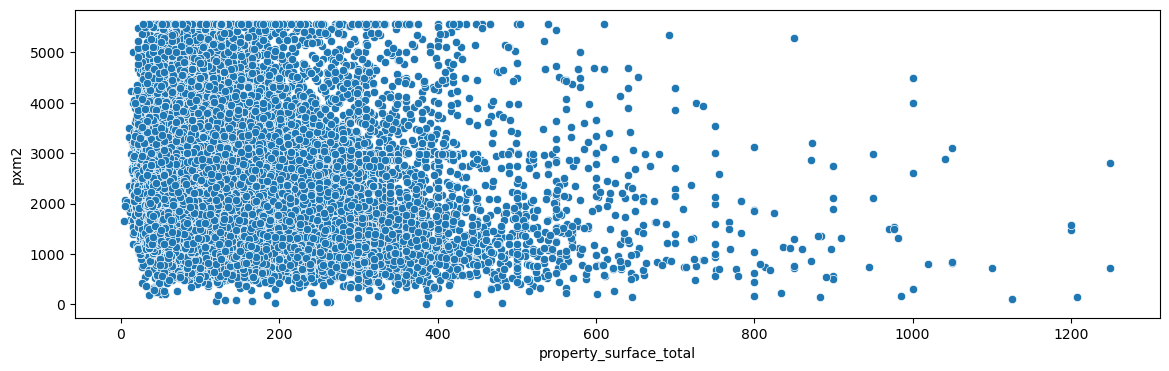

In [17]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2") 
plt.show()

Distribución dividiendo el precio por metro cuadrado en partes iguales.

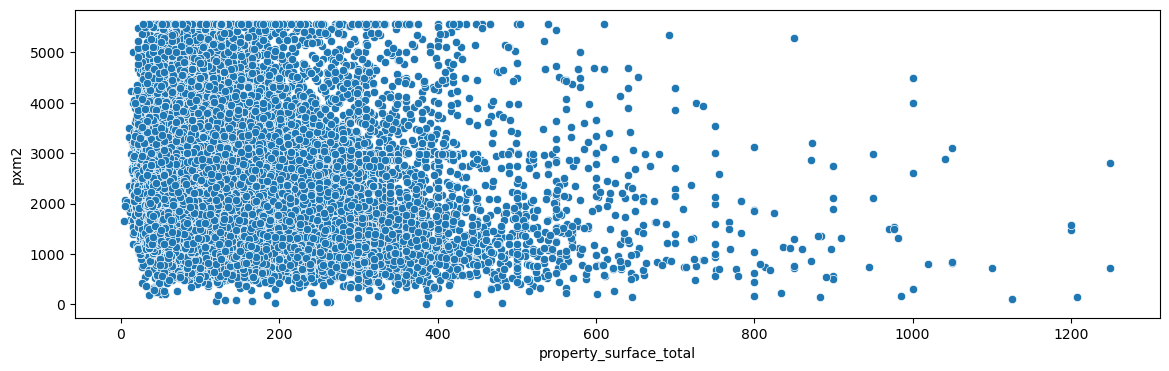

In [18]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2") 
plt.show()

Distrubución 25% bajo, 50% medio, 25% alto.

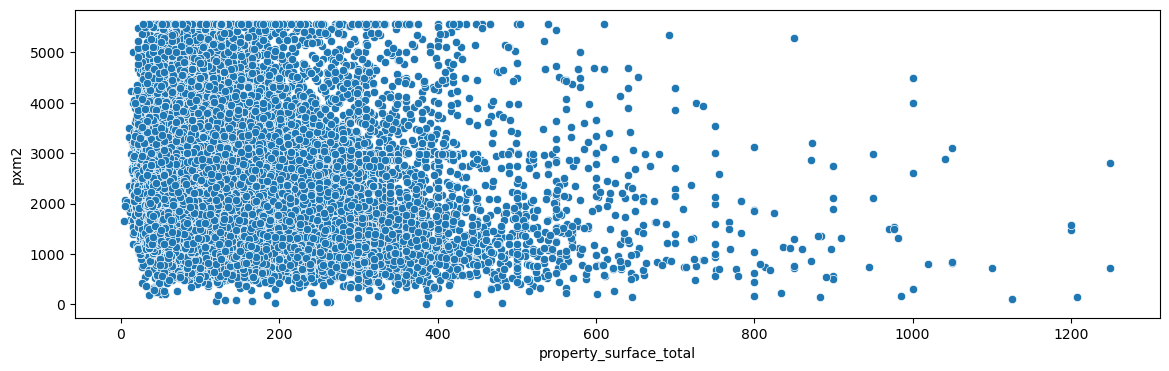

In [19]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2") 
plt.show()

Distribucion agrupando previamente por tipo de propiedad, se observa como se mezclan las categorias a diferencia de los dos casos anteriores.

### Mostrar la distribucion del precio por metro cuadrado por tipo de propiedad

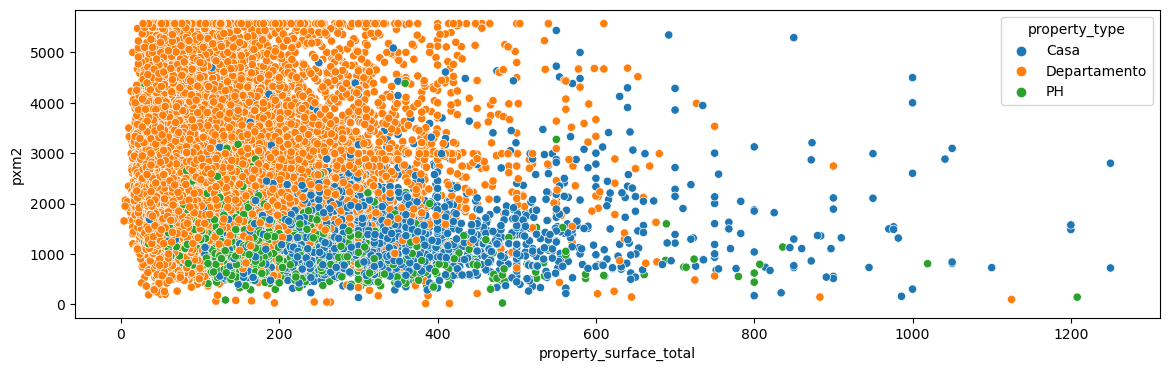

In [20]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2", hue="property_type")
plt.show() 

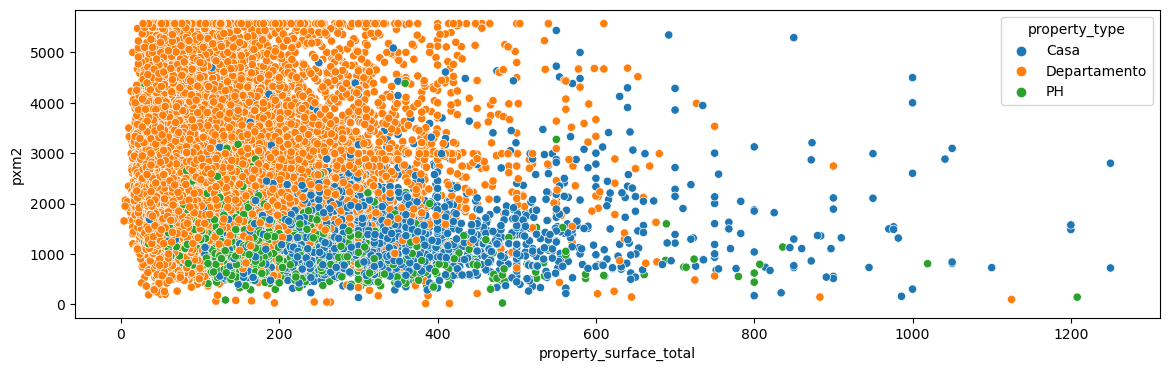

In [21]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2", hue="property_type")
plt.show()

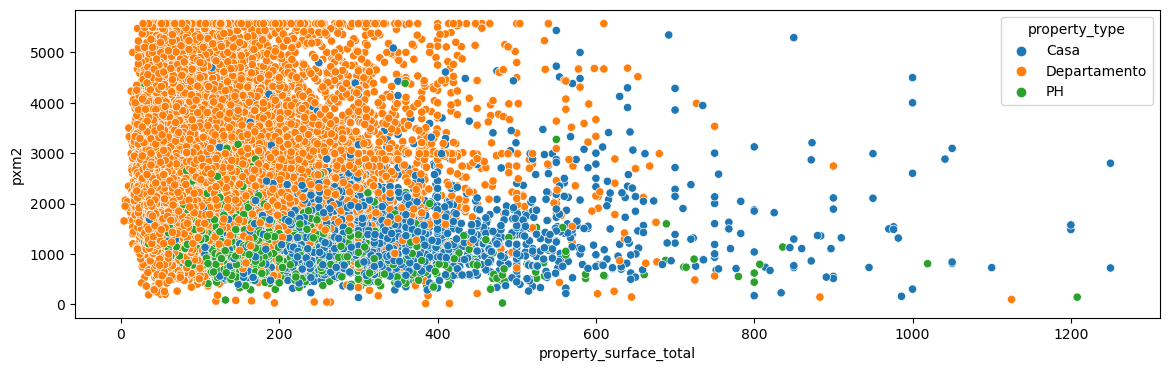

In [22]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2", hue="property_type") 
plt.show()

### Por cada una de las tres alternativas mostrar graficamente la distribución de la nueva variable creada tipo_precio

Agrupamiento en tres partes iguales

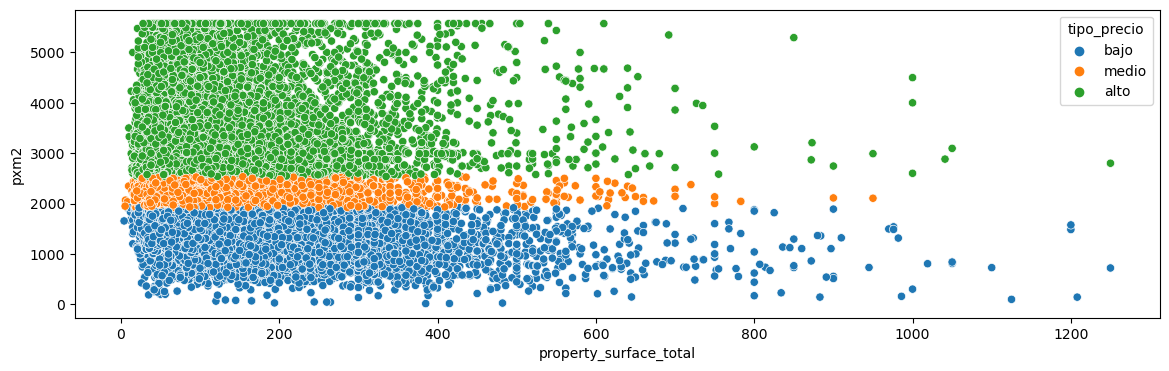

In [23]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

Agrupamiento en tres partes, primera y ultima con 25% cada una, parte del medio con 50%

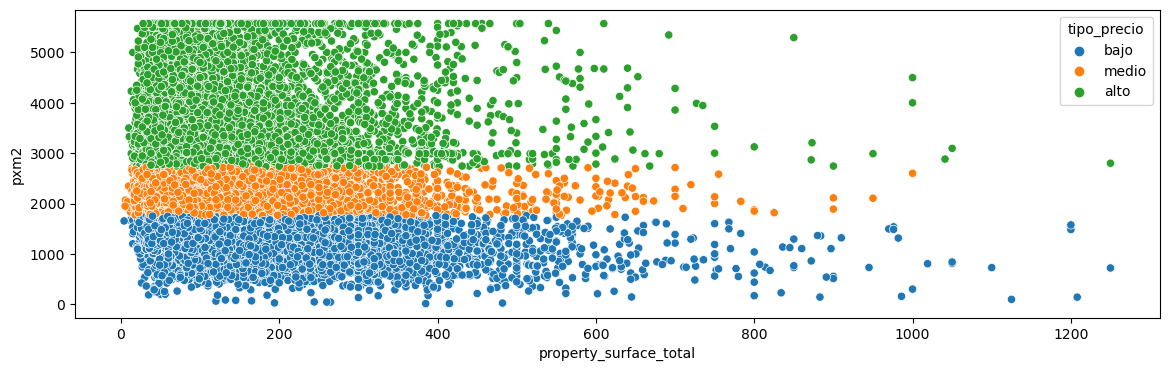

In [24]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

Agrupamiento primero por tipo de propiedad, luego como en el item anterior

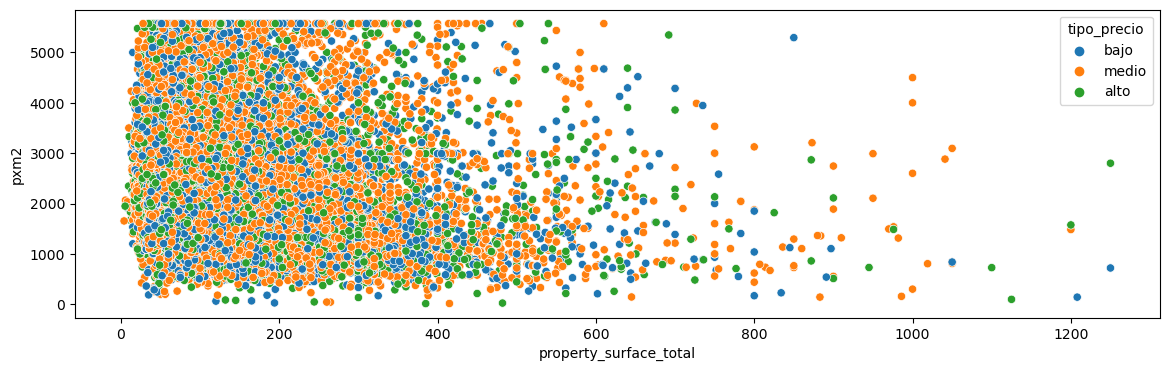

In [25]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

### Seleccionar una de las alternativas, justificando la misma

In [26]:
df_tprecio = df_tprecio2 
df_tprecio

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,pxm2,tipo_precio
0,-34.589974,-58.459133,Palermo,Casa,4,3,171.000000,133.0,210000.0,1228.0,bajo
1,-34.637319,-58.361124,Boca,Departamento,3,2,58.000000,55.0,82900.0,1429.0,bajo
2,-34.628647,-58.361871,Boca,Departamento,4,3,70.000000,70.0,99000.0,1414.0,bajo
3,-34.610027,-58.401934,Once,Departamento,4,2,135.327513,104.0,146000.0,1079.0,bajo
4,-34.631621,-58.416825,Boedo,PH,4,2,106.415511,73.0,250000.0,2349.0,medio
...,...,...,...,...,...,...,...,...,...,...,...
82658,-34.603245,-58.489810,Villa del Parque,Departamento,4,3,130.000000,100.0,220000.0,1692.0,bajo
82659,-34.614063,-58.482814,Villa del Parque,Departamento,3,2,68.000000,60.0,161000.0,2368.0,medio
82660,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,51.000000,30.0,75500.0,1480.0,bajo
82661,-34.614175,-58.479062,Villa del Parque,Departamento,1,1,37.000000,31.0,74500.0,2014.0,medio


Seleccionamos la segunda alternativa antes que la primera debido a que preferimos un agrupamiento equitativo (en cantidad), la tercer alternativa la descartamos ya que podemos notar que si primero agrupamos por propiedad y luego por tipo de precio obtenemos un resultado desordenado.

### Comparar, si aplica, la alternativa seleccionada con la division en 3 grupos obtenida utilizando agrupamiento por K Means

In [27]:
df_kmeans=pd.read_csv("./data/punto2.csv")

In [28]:
plt.scatter(df_kmeans.longitud, df_kmeans.property_price, c=df_kmeans.colores2, s=50, cmap='viridis')
plt.xlabel('longitud')
plt.ylabel('property price')
plt.title('scatter plot')

Text(0.5, 1.0, 'scatter plot')

In [29]:
sns.scatterplot(data=df_tprecio, x='longitud', y="pxm2", hue="tipo_precio") 

<AxesSubplot:title={'center':'scatter plot'}, xlabel='longitud', ylabel='property price'>

Se pueden comparar con la alternativa seleccionada ya que, como en el gráfico de kmeans, se puede observar que mientras más a la derecha vas mayor porcentaje de precios altos hay, esto quiere decir que, en barrios como podría ser Palermo el precio por metro cuadrado y su precio real son más elevados que en otras zonas. 

### Mostrar en un mapa de CABA los avisos coloreados por tipo_precio

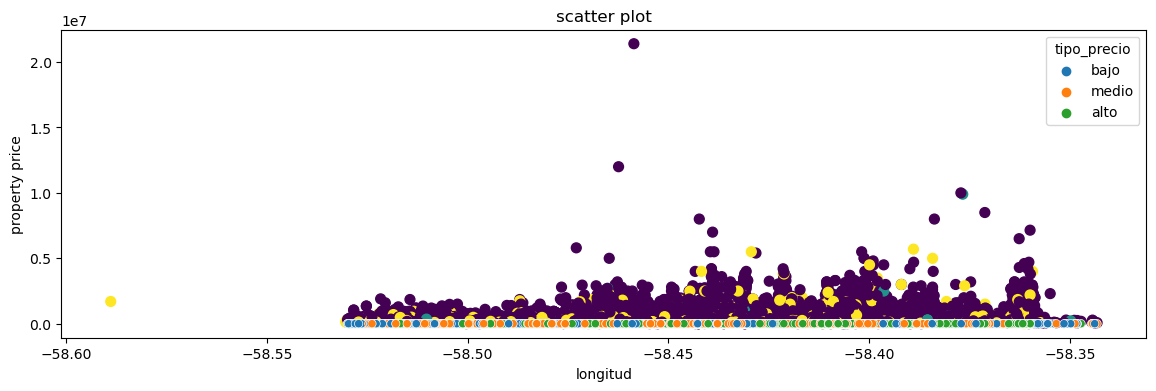

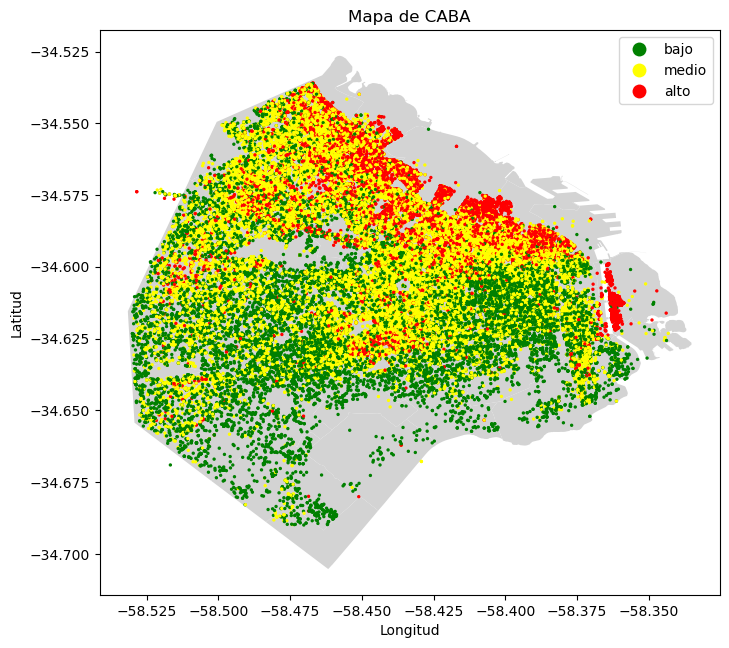

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
barrios = gp.read_file("barrios.geojson")
ax.set_title('Mapa de CABA')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
barrios.plot(ax=ax,column='BARRIO', color='lightgrey')

color_dict = {'bajo':'green',  
              'medio':'yellow',
              'alto':'red' }

puntos = gp.GeoDataFrame(df_tprecio.tipo_precio, geometry=gp.points_from_xy(df_tprecio.longitud, df_tprecio.latitud))    
puntos.plot(ax = ax, column='tipo_precio', markersize=2, legend=True, 
            cmap=colors.ListedColormap(list(color_dict.values())))

plt.show()

# Ejercicio 3b

Entrenamiento y predicción. Predecir el valor del atributo tipo_precio, excluyendo del entrenamiento la variable price, pxm2, y cualquier otra variable que pueda contener información del precio de venta.

Realizar las tareas de ingeniería de características necesarias para trabajar con cada algoritmos (encoding, normalización, etc).

In [31]:
df_EyP=df_tprecio.copy()

In [32]:
df_EyP.dtypes

latitud                      float64
longitud                     float64
place_l3                      object
property_type                 object
property_rooms                 int64
property_bedrooms              int64
property_surface_total       float64
property_surface_covered     float64
property_price               float64
pxm2                         float64
tipo_precio                 category
dtype: object

Quito variables indicativas del precio de venta:

In [33]:
df_EyP.drop(['property_price', 'pxm2'], axis=1, inplace=True)

## Modelo 1 - Árbol de decisión

### Metricas

- **Accuracy:**
El calculo de la precisión de una clasificacion mide la cantidad de casos verdaderos acertados en base al total de casos detectados.

- **Recall:** 
Calcula la cantidad de casos verdaderos acertados en base a la totalidad de casos detectados, debido a que nuestro analisis es multiclase, debemos utilizar una de las siguientes medidas:
- Macro-recall: promedio del recall score de cada clase.
- Weighted-recall: ponderado del recall score de cada clase.
- Micro-recall: precisión general del modelo.

- **f1 score:**
Combinación de las medidas de precisión y recall en un sólo valor, debido a que nuestro analisis es multiclase, debemos utilizar una de las siguientes medidas:
- Macro-f1: promedio del f1 score de cada clase.
- Weighted-f1: ponderado del f1 score de cada clase.
- Micro-f1: el valor de Micro-recall.

En este caso utilizaremos Weigthed-recall y Weighted-f1

### Ajuste del dataset 

Creamos una copia del dataset del punto 1d:

In [34]:
df_dTree=df_EyP.copy()

Transformo variables categoricas para poder utilizarlas como predictorias

In [35]:
df_dTree = pd.get_dummies(df_dTree, columns=["place_l3","property_type"], drop_first=True)
df_dTree.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,tipo_precio,place_l3_Agronomía,place_l3_Almagro,place_l3_Balvanera,...,place_l3_Villa Ortuzar,place_l3_Villa Pueyrredón,place_l3_Villa Real,place_l3_Villa Riachuelo,place_l3_Villa Santa Rita,place_l3_Villa Soldati,place_l3_Villa Urquiza,place_l3_Villa del Parque,property_type_Departamento,property_type_PH
0,-34.589974,-58.459133,4,3,171.000000,133.0,bajo,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-34.637319,-58.361124,3,2,58.000000,55.0,bajo,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-34.628647,-58.361871,4,3,70.000000,70.0,bajo,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-34.610027,-58.401934,4,2,135.327513,104.0,bajo,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-34.631621,-58.416825,4,2,106.415511,73.0,medio,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Variables (features) que clasifican y variable (target) a la que quiero calcular

In [36]:
#Creo un dataset con los features que voy a usar para clasificar
df_dTree_x=df_dTree.drop(['tipo_precio'], axis='columns', inplace=False)

#Creo un dataset con la variable target
df_dTree_y = df_dTree['tipo_precio'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_dTree_x, 
                                                    df_dTree_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2)

### Prueba con el modelo sin optimización

In [37]:
arbolcv=DecisionTreeClassifier()

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier()

In [38]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['alto', 'medio', 'medio', ..., 'bajo', 'medio', 'bajo'],
      dtype=object)

In [39]:
y_test.values

['alto', 'medio', 'medio', 'medio', 'alto', ..., 'medio', 'alto', 'medio', 'medio', 'medio']
Length: 16533
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [40]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6746506986027944
Recall: 0.6746506986027944
f1 score: 0.6749148914979928


In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.63      0.66      0.65      4016
        bajo       0.67      0.68      0.68      4183
       medio       0.70      0.68      0.69      8334

    accuracy                           0.67     16533
   macro avg       0.67      0.67      0.67     16533
weighted avg       0.68      0.67      0.67     16533



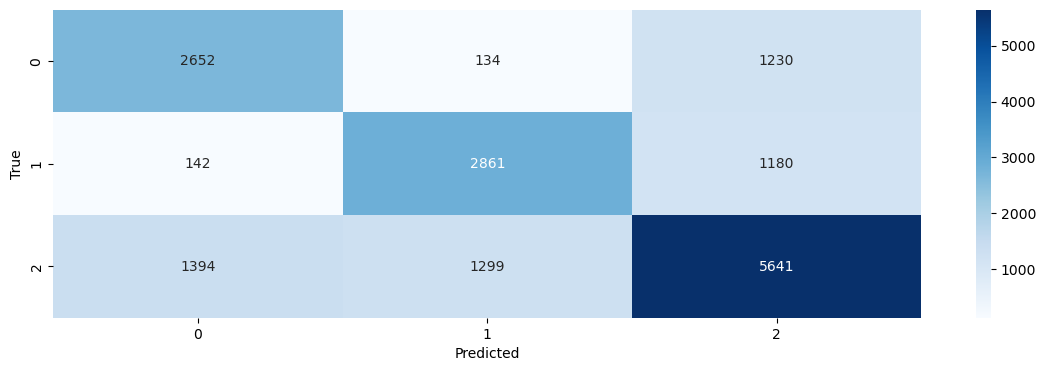

In [42]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

El modelo clasifica correctamente mas de lo que hace erroneamente.

### Optimización de hiperparametros

In [43]:
print(x_train.shape[0])

66130


La cantidad de entradas en nuestro conjunto de entrenamiento es de 66130, elejimos una cantidad de folds de manera tal que quede cada subconjunto con igual cantidad de entradas.

In [44]:
folds = 10

In [45]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,10), 
               'max_depth':list(range(1,16))}
                
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

grid_search = GridSearchCV(
                estimator=base_tree,
                param_grid=params_grid, 
                cv = kfoldcv, 
                n_jobs = -1,
                return_train_score='True'
            )

grid_search.fit(x_train, y_train)

In [ ]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

Atributos considerados y su importancia

In [ ]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_dTree.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

Nuestro atributo de mayor importancia es la latitud sobre la cual se ubica la propiedad.

### Construcción del árbol de decisión con mejores parametros

Creamos el árbol con los mejores hiperparametros obtenidos en el item anterior y lo entrenamos

In [ ]:
arbolcv=DecisionTreeClassifier().set_params(**grid_search.best_params_)

arbolcv.fit(x_train,y_train)

#### Grafico del árbol de decisión

In [ ]:
plt.figure(figsize=(50,50))

tree_plot=tree.plot_tree(arbolcv,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])
plt.show(tree_plot)

#### Analisis del árbol de decisión

In [ ]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

El criterio principal de categorización es el de la latitud, zona norte o zona sur de CABA, los departamentos de zona norte son considerados de tipo de precio alto si se ubican cercanas al rio (Belgrano, Palermo, etc) y de precio medio en caso contrario. Los departamentos de zona sur son de precio alto si se encuentran dentro de Puerto Madero. Los PH y Casas de zona sur son de precio bajo, mientras que las de zona norte son de precio medio.

### Evaluación de la performance del árbol en el conjunto de evaluación

Entrenamos al modelo y vemos valores predichos

In [ ]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

Valores reales

In [ ]:
y_test.values

Evaluación performance en el conjunto de evaluación.

In [ ]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

In [ ]:
print(classification_report(y_test,y_pred))

Matriz de confusión

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Agregar explicación de la matriz.

### Entrenamiento con PCA

#### Ajuste del dataset

In [ ]:
df_EyP_pca=pd.read_csv('./data/properati_argentina_2021_pca.csv')
df_EyP_pca.dtypes

Agregamos columna tipo_precio  al dataset

In [ ]:
df_EyP_pca["tipo_precio"] = df_EyP["tipo_precio"]
df_EyP_pca.drop("Unnamed: 0",axis=1, inplace=True) # Unnamed: 0 se saca guardando el csv sin indice -> df.to_csv(path, index=False)
df_EyP_pca.head(5)

In [ ]:
# El dataset probablemente tenga valores nan porque no se corre hace mucho
df_EyP_pca.dropna(inplace=True)
df_EyP_pca.isna().sum()

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
df_dTree_x=df_EyP_pca.drop(['tipo_precio'], axis='columns', inplace=False)

#Creo un dataset con la variable target
df_dTree_y = df_EyP_pca['tipo_precio'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_dTree_x, 
                                                    df_dTree_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2)

#### Prueba con el modelo sin optimización

In [ ]:
arbolcv=DecisionTreeClassifier()

arbolcv.fit(x_train,y_train)

In [ ]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

In [ ]:
y_test.values

In [ ]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

In [ ]:
print(classification_report(y_test,y_pred))

Podemos observar que inicialmente la performance del modelo PCA es drasticamente peor que el del dataset con sus dimensiones no reducidas.

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Optimización de hiperparametros

In [ ]:
folds = 10

In [ ]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,10), 
               'max_depth':list(range(1,16))}
                
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

grid_search = GridSearchCV(
                estimator=base_tree,
                param_grid=params_grid, 
                cv = kfoldcv, 
                n_jobs = -1,
                return_train_score='True'
            )

grid_search.fit(x_train, y_train)

In [ ]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

In [ ]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_EyP_pca.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

Vemos que cp_3 es el atributo de mayor importancia.

#### Construcción del árbol de decisión

Creamos el árbol con los mejores hiperparametros obtenidos en el item anterior y lo entrenamos

In [ ]:
arbolcv=DecisionTreeClassifier().set_params(**grid_search.best_params_)

arbolcv.fit(x_train,y_train)

#### Grafico del árbol de decisión

In [ ]:
plt.figure(figsize=(50,50))

tree_plot=tree.plot_tree(arbolcv,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])
plt.show(tree_plot)

#### Analisis del árbol de decisión

In [ ]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

EXPLICAR REGLAS DEL ARBOL

#### Evaluación de la performance del árbol de decisión

Entrenamos al modelo y vemos valores predichos

In [ ]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

In [ ]:
y_test.values

Evaluación performance en el conjunto de evaluación.

In [ ]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AGREGAR EXPLICACIÓN DE LA MATRIZ

## Modelo 2 - Random forest

### Metricas

- **RMSE:**

Agregar metricas

### Ajuste del dataset

In [ ]:
df_randomF = df_EyP.copy()
df_randomF = pd.get_dummies(df_randomF, columns=["place_l3","property_type"], drop_first=True)
df_randomF['tipo_precio'] = pd.factorize(df_randomF.tipo_precio)[0]
df_randomF.head()

In [ ]:
df_randomF_x = df_randomF.drop(columns = "tipo_precio")
df_randomF_y = df_randomF['tipo_precio']

#Generamos los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(
                                        df_randomF_x, 
                                        df_randomF_y, 
                                        test_size=0.2,  #proporcion 80/20
                                        random_state=42
                                    )

### Prueba con el modelo sin optimización

In [ ]:
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(x_train, y_train)

In [ ]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''


In [ ]:
# Error test del modelo inicial
y_pred = random_forest.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

In [ ]:
y_pred

In [ ]:
y_test.values

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
#Matriz de Confusión

cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Notamos que a diferencia del árbol de decisión, el random forest tiende a clasificar a las propiedades como precio bajo.

### Optimizamos los hiperparámetros

In [ ]:
param_dist = {
            'max_depth': list(range(1,16)),
            #'min_samples_leaf': [5,10,20,50,100,200],
            #'n_estimators': [10,25,30,50,100,200],
            #'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5) # 5 folds para cross validation

grid_search = GridSearchCV(
                random_forest,
                param_grid=param_dist, 
                cv = kfoldcv, 
                n_jobs = -1
            )

grid_search.fit(x_train, y_train)

In [ ]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

Atributos considerados y su importancia

In [ ]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_randomF.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

Nuestro atributo de mayor importancia es...

### Construcción del árbol con mejores parametros

In [ ]:
random_forest = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_)

random_forest.fit(x_train, y_train)

#### Grafico del árbol

In [ ]:
plt.figure(figsize=(50,50))

'''tree_plot=tree.plot_tree(random_forest,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])'''

tree_plot=tree.plot_tree(grid_search.best_estimator_[5], 
                         feature_names = df_randomF_x.columns,
                         filled=True,
                         max_depth=2,
                         class_names=['bajo', 'medio', 'alto'])

plt.show(tree_plot)

#### Analisis del árbol de decisión

In [ ]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

EXPLICAR REGLAS DEL ARBOL

### Evaluación de la performance del árbol en el conjunto de evaluación

In [ ]:
random_forest.fit(x_train, y_train)

Error luego de setear los hiperparámetros

In [ ]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

In [ ]:
y_pred = random_forest.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

In [ ]:
y_pred

In [ ]:
y_test.values

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Entrenamiento con PCA

#### Ajuste del dataset

In [ ]:
df_randomF_pca=pd.read_csv('./data/properati_argentina_2021_pca.csv')

df_randomF_pca["tipo_precio"] = df_EyP["tipo_precio"]
df_randomF_pca.drop("Unnamed: 0",axis=1, inplace=True)

df_randomF_pca.dropna(inplace=True)

In [ ]:
df_randomF_pca_x = df_randomF_pca.drop(columns = "tipo_precio")
df_randomF_pca_y = df_randomF_pca['tipo_precio']

#Generamos los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(
                                        df_randomF_pca_x, 
                                        df_randomF_pca_y, 
                                        test_size=0.2,  #proporcion 80/20
                                        random_state=42
                                    )

#### Prueba con el modelo sin optimización

In [ ]:
random_forest_pca = RandomForestClassifier(random_state=42)
random_forest_pca.fit(x_train, y_train)

In [ ]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

In [ ]:
y_pred = random_forest_pca.predict(X = x_test)

'''rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")'''

In [ ]:
y_pred

In [ ]:
y_test.values

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

EXPLICAR MATRIZ DE CONFUSIÓN

#### Optimización de hiperparametros

In [ ]:
param_dist = {
            'max_depth': list(range(1,16)),
            #'min_samples_leaf': [5,10,20,50,100,200],
            #'n_estimators': [10,25,30,50,100,200],
            #'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5) # 5 folds para cross validation

grid_search = GridSearchCV(
                random_forest_pca,
                param_grid=param_dist,
                cv = kfoldcv, 
                n_jobs = -1
            )

grid_search.fit(x_train, y_train)

In [ ]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

Atributos considerados y su importancia

In [ ]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_randomF_pca.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

Nuestro atributo de mayor importancia es...

#### Construcción del árbol con mejores parametros

In [ ]:
random_forest_pca = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_)

random_forest_pca.fit(x_train, y_train)

#### Grafico del árbol

In [ ]:

plt.figure(figsize=(50,50))

'''tree_plot=tree.plot_tree(random_forest,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])'''

tree_plot=tree.plot_tree(grid_search.best_estimator_[5], 
                         feature_names = df_randomF_pca_x.columns,
                         filled=True,
                         max_depth=2,
                         class_names=['bajo', 'medio', 'alto'])

plt.show(tree_plot)

##### Analisis del árbol de decisión

In [ ]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

EXPLICAR REGLAS DEL ARBOL

#### Evaluación de la performance del árbol en el conjunto de evaluación

In [ ]:
random_forest_pca.fit(x_train, y_train)

Error luego de setear los hiperparámetros

In [ ]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

In [ ]:
y_pred = random_forest_pca.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

In [ ]:
y_pred

In [ ]:
y_test.values

## Modelo 3 - KNN

In [ ]:
df_KNN=df_EyP.copy()
df_KNN

In [ ]:
df_KNN = pd.get_dummies(df_KNN, columns=["place_l3","property_type"], drop_first=True)

In [ ]:
df_KNN['tipo_precio'] = df_KNN['tipo_precio'].map({'bajo':0,'medio':1,'alto':2},na_action=None)
df_KNN['tipo_precio'].astype('int64')

In [ ]:
df_KNN.head()

In [ ]:
# Seleccione variable para predecir
X = df_KNN.drop(["tipo_precio"], axis=1)
y = df_KNN[['tipo_precio']]

#Separacion Train/test  (80/20) según lo pedido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)

In [ ]:
#Creamos el modelo
knn = KNeighborsClassifier()

#Miramos los parámetros por defecto
knn.get_params()

In [ ]:
# Variamos la cantidad de vecinos (K)
metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 200,5) # vecinos desde 1 hasta 200 con intervalos de 5

for n in k_range:

    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    metrics.append((n, int((y_test == y_pred).sum())))

In [ ]:
# ploteamos
df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

En el intervalo 1 a 15 se ve que la performance es mejor, variamos la cantidad de vecinos a ese rango

In [ ]:
metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 15,1) # vecinos desde 1 hasta 15 con salto de 1

for n in k_range:

    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    metrics.append((n, int((y_test == y_pred).sum())))

Volvemos a plottear

In [ ]:
df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

In [ ]:
params_grid = { 'n_neighbors':range(1,15,1), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['cityblock',
              'euclidean',
              'manhattan',]
             }
params_grid

In [ ]:
cantidad_tuplas = 1
for param in params_grid:
    cantidad_tuplas *= len(params_grid[param])
cantidad_tuplas

In [ ]:
#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(knn, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

Mejores parametros

In [ ]:
print(grid.best_params_)

Mejor metrica

In [ ]:
print(grid.best_score_)

In [ ]:
#Mejor estimador
best_knn=grid.best_estimator_

#Predicción con mejor estimador
y_pred_test=best_knn.predict(X_test)
y_pred_train=best_knn.predict(X_train)

In [ ]:
predicciones = best_knn.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

In [ ]:
# Matriz
mc = confusion_matrix(y_test, predicciones)
print(mc)

# Heatmap
sns.heatmap(mc, annot=True, fmt='g', cmap=sns.cubehelix_palette(as_cmap=True))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Podemos observar que ambos arboles de decisión crean reglas que uno puede asumir como correctas, si el barrio es puerto madero, o que los edificios que se ubican en zona norte de la capital tienden a ser de un tipo de precio mas elevado.
El tercer modelo elegido, KNN, no dar estimaciones correctas.

# Conclusiones

Se pudieron observar como los distintos modelos crean reglas que podemos tomar como las correctas tienden a se de un tipo de precio más elevado, como por ejemplo, el Árbol de decisión se puede ver que los precios son más altos
si el inmobiliario esta cerca de un río o si se encuentran dentro de barrios como 'Puerto Madero'. Pero con el 
tercer modelo elegido no pudimos dar estimaciones correctas acerca de como varían los precios.